In [34]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

In [ ]:
!pip install plotly

In [35]:
data = pd.read_csv("C:/Users/LENOVO/OneDrive/Desktop/Ads-CTR-Forecasting/ctr.csv")

In [36]:
print(data.head())

         Date  Clicks  Impressions
0  2022-10-19    2851        58598
1  2022-10-20    2707        57628
2  2022-10-21    2246        50135
3  2022-10-22    1686        40608
4  2022-10-23    1808        41999


In [37]:
#data preparation
data['Date']=pd.to_datetime(data['Date'], format='%Y-%m-%d')

In [38]:
data.set_index('Date', inplace=True)

In [39]:
print(data.head())

            Clicks  Impressions
Date                           
2022-10-19    2851        58598
2022-10-20    2707        57628
2022-10-21    2246        50135
2022-10-22    1686        40608
2022-10-23    1808        41999


In [40]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['Clicks'], mode='lines', name='Clicks'))
fig.add_trace(go.Scatter(x=data.index, y=data['Impressions'], mode='lines', name='Impressions'))
fig.update_layout(title='Clicks and Impressions Over Time')
fig.show()

In [41]:
# Create a scatter plot to visualize the relationship between Clicks and Impressions
fig = px.scatter(data, x='Clicks', y='Impressions', title='Relationship between Clicks and Impressions',
                labels={'Clicks':'Clicks', 'Impressions':'Impressions'})

#customize the layout
fig.update_layout(xaxis_title='Clicks', yaxis_title='Impressions')

#Show the plot
fig.show()

In [42]:
# So, the relationship between clicks and impressions is linear. It means higher ad impressions result in higher ad clicks.
# Now, let’s calculate and visualize CTR over time:
# Calculate and visualize CTR
data['CTR'] = (data['Clicks'] / data['Impressions']) * 100
fig = px.line(data, x=data.index, y='CTR', title='Click-Through Rate (CTR) Over Time')
fig.show()

In [43]:
#Now, let’s have a look at the average CTR by day of the week:
data['DayOfWeek'] = data.index.dayofweek
data['WeekOfMonth'] = data.index.week // 4

#EDA based on DayOfWeek
day_of_week_ctr = data.groupby('DayOfWeek')['CTR'].mean().reset_index()
day_of_week_ctr['DayOfWeek'] = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

fig = px.bar(day_of_week_ctr, x='DayOfWeek', y='CTR', title='Average CTR by Day of the Week')
fig.show()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_19760\3175627603.py:3: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)



In [44]:
#Now, let’s compare the CTR on weekdays and weekends:

# Create a new column 'DayCategory' to categorize weekdays and weekends
data['DayCategory'] = data['DayOfWeek'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Calculate average CTR for weekdays and weekends
ctr_by_day_category = data.groupby('DayCategory')['CTR'].mean().reset_index()

# Create a bar plot to compare CTR on weekdays vs. weekends
fig = px.bar(ctr_by_day_category, x='DayCategory', y='CTR', title='Comparison of CTR on Weekdays vs. Weekends',
             labels={'CTR': 'Average CTR'})

# Customize the layout
fig.update_layout(yaxis_title='Average CTR')

# Show the plot
fig.show()

In [45]:
#Now, let’s compare the impressions and clicks on weekdays and weekends:
# Group the data by 'DayCategory' and calculate the sum of Clicks and Impressions for each category
grouped_data = data.groupby('DayCategory')[['Clicks', 'Impressions']].sum().reset_index()

# Create a grouped bar chart to visualize Clicks and Impressions on weekdays vs. weekends
fig = px.bar(grouped_data, x='DayCategory', y=['Clicks', 'Impressions'],
             title='Impressions and Clicks on Weekdays vs. Weekends',
             labels={'value': 'Count', 'variable': 'Metric'},
             color_discrete_sequence=['blue', 'green'])

# Customize the layout
fig.update_layout(yaxis_title='Count')
fig.update_xaxes(title_text='Day Category')

# Show the plot
fig.show()

C:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



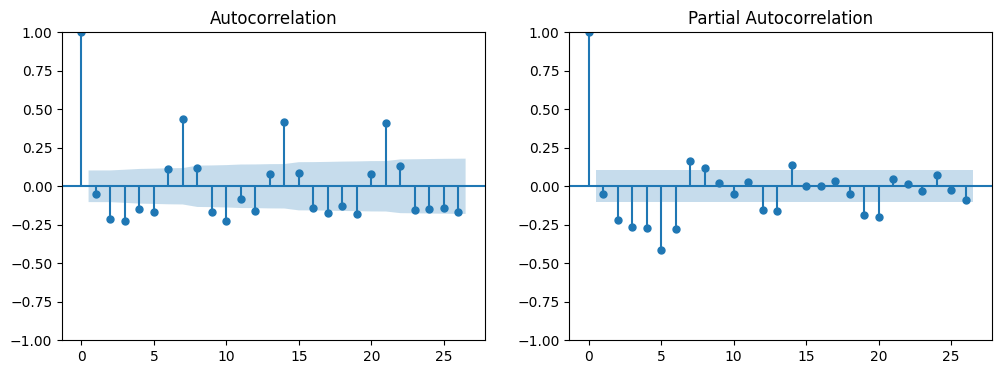

In [46]:
#Now, let’s see how to forecast the Ads CTR. As CTR is dependent on impressions and impressions change over time,
#we can use Time Series forecasting techniques to forecast CTR. 
#As CTR is seasonal, let’s calculate the p, d, and q values for the SARIMA model:

data.reset_index(inplace=True)

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# resetting index
time_series = data.set_index('Date')['CTR']

# Differencing
differenced_series = time_series.diff().dropna()

# Plot ACF and PACF of differenced time series
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(differenced_series, ax=axes[0])
plot_pacf(differenced_series, ax=axes[1])
plt.show()

In [47]:
# And as we are using the SARIMA model here, the value of s will be 12.

# Now, let’s train the forecasting model using SARIMA:
from statsmodels.tsa.statespace.sarimax import SARIMAX

p, d, q, s = 1, 1, 1, 12

model = SARIMAX(time_series, order=(p, d, q), seasonal_order=(p, d, q, s))
results = model.fit()
print(results.summary())

C:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                                     SARIMAX Results                                      
Dep. Variable:                                CTR   No. Observations:                  365
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -71.365
Date:                            Tue, 30 Jul 2024   AIC                            152.730
Time:                                    11:58:50   BIC                            172.048
Sample:                                10-19-2022   HQIC                           160.418
                                     - 10-18-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5274      0.070      7.502      0.000       0.390       0.665
ma.L1         -0.9045      0.036   

C:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [48]:
# Now, here’s how to predict the future CTR values:

# Predict future values
future_steps = 100
predictions = results.predict(len(time_series), len(time_series) + future_steps - 1)
print(predictions)

2023-10-19    3.852928
2023-10-20    3.889921
2023-10-21    3.820605
2023-10-22    3.727259
2023-10-23    3.710022
                ...   
2024-01-22    3.545900
2024-01-23    3.466992
2024-01-24    3.561525
2024-01-25    3.547037
2024-01-26    3.580426
Freq: D, Name: predicted_mean, Length: 100, dtype: float64


In [49]:
# Now, let’s visualize the forecasted trend of CTR:

# Create a DataFrame with the original data and predictions
forecast = pd.DataFrame({'Original': time_series, 'Predictions': predictions})

# Plot the original data and predictions
fig = go.Figure()

fig.add_trace(go.Scatter(x=forecast.index, y=forecast['Predictions'],
                         mode='lines', name='Predictions'))

fig.add_trace(go.Scatter(x=forecast.index, y=forecast['Original'],
                         mode='lines', name='Original Data'))

fig.update_layout(title='CTR Forecasting',
                  xaxis_title='Time Period',
                  yaxis_title='Impressions',
                  legend=dict(x=0.1, y=0.9),
                  showlegend=True)

fig.show()

In [50]:
import os
print(os.getcwd())

C:\Users\LENOVO


In [51]:
file_name = "Ads-CTR-Forecasting.py"  # Replace with your actual file name
file_path = os.path.join(os.getcwd(), file_name)
print(file_path)

C:\Users\LENOVO\Ads-CTR-Forecasting.py
